In [7]:
import numpy as np
import xcompy as xc
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import itertools
import copy
from materials import convert_nist_str

In [3]:

mat1 = 'ICRU tissue'
matcomp1 = 'H(10.2)C(14.3)N(3.4)O(70.8)Na(0.2)P(0.3)S(0.3)Cl(0.2)K(0.3)'  
matcomp2 = 'H(3.4)C(15.5)N(4.2)O(43.5)Na(0.1)Mg(0.2)P(10.3)S(0.3)Ca(22.5)' 
density2 = 1.92 # g/cm3

#y1 = xc.mixatten(matcomp1, E)
#y2 = xc.mixatten(matcomp2, E)
#y3 = xc.mixatten('H(11.2)O(88.8)', E)

In [4]:
# plot style

#marker = itertools.cycle(('o', 's', '*', '+', 'x')) 
marker = itertools.cycle(('*', '+', 'x')) 
colors_default = plt.rcParams['axes.prop_cycle'].by_key()['color']
color1 = itertools.cycle(colors_default)
color2 = itertools.cycle(colors_default)

plt.rcParams.update({
    # figure
    "figure.dpi": 300,   # higher quality image
    # text
    "font.size":10,
    "font.family": "serif",                  # uncomment for tex style
    "font.serif": ['Computer Modern Roman'], # uncomment for tex style
    "text.usetex": True,                     # uncomment for tex style
    # axes
    "axes.titlesize": 10,
    "axes.labelsize": 8,
    "axes.linewidth": 1,
    # ticks
    "xtick.top": True,
    "ytick.right": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.labelsize":8,
    "ytick.labelsize":8,
    # grid
    "axes.grid" : True,
    "axes.grid.which" : "major",
     "grid.color": "lightgray",
     "grid.linestyle": ":",
     # legend
     "legend.fontsize":8,
    "legend.facecolor":'white',
    "legend.framealpha":1.0 ,  
     })


In [ ]:
from materials import Material, all_mats, mdict

target_mats = ['water',
               'air',
               'calcium',
               'iodine',
               'bone',
               'fat'
               #'iodine_in_water_20', 
               #'calcium_in_water_600'
              ]

# list of densities
iodine_density = np.array([2, 2.5, 5, 7.5, 10, 15, 20, 1000])*1e-3
calcium_density = np.array([50, 100, 200, 300, 400, 500, 600, 1000])*1e-3

mats = []
for m in all_mats:
    if m.name in target_mats:
        print(m.name)
        
        if m.name=='iodine':  # manual densities
            for d in iodine_density:
                m2 = copy.copy(m)
                m2.set_density(d)
                mats.append(m2)
        elif m.name=='calcium': # manual densities
            for d in calcium_density:
                m2 = copy.copy(m)
                m2.set_density(d)
                mats.append(m2)
        else:
            mats.append(m)
        if m.name=='water':
            water=m
        print()
        

# mats = []
# for m in all_mats:
#     if m.name != 'iodine':
#         mats.append(m)
#         print(m.name)
#     if m.name == 'calcium_in_water_600':
#         print(m.matcomp)

[[m.name, m.density] for m in mats]

In [ ]:
# choose dual energies
E1 = 51.
E2 = 65.
E = np.array([E1, E2])

# define example measurement
mu_meas = np.array([0.27, 0.165])

# example out
mu_meas_out = np.array([0.6,0.43])

# initialize attenuation coeff vectors 
# create full tesselation of triplets
water.init_atten_coeffs(E)
points = []
for mat in mats:
    mat.init_atten_coeffs(E)
    if mat.name=='calcium' or mat.name=='iodine': # dilute! 
        mat.add_water()
        #mu_vals = water.mu+mat.mu
        #points.append(mu_vals)
    points.append(mat.mu)
    #print(mat.mu)
points = np.array(points)

# create tesselation
tri = Delaunay(points)
#print(tri.simplices)

# check tesselaation

fig, ax = plt.subplots(1,1, figsize=[8,6])
fig.suptitle(f'$E_1, E_2 =$ {E1}, {E2} keV')
plt.plot(M_E1.ravel(), M_E2.ravel(), 'g.', markersize=.1, label='image data')

ax.triplot(points[:,0], points[:,1], tri.simplices, 'k--', lw=.8, alpha=0.7)
for mat in mats:
    #ax.plot(mat.mu[0], mat.mu[1], marker=next(marker), ls='', markerfacecolor='None', label=mat.name)
    if mat.name=='iodine':
        mark = 'o'
        col='b' #col=next(color1)
    elif mat.name=='calcium':
        mark = 's'
        col='r' #col=next(color2)    
    else:
        mark = next(marker)
        col=None
    
    ax.plot(mat.mu[0], mat.mu[1], marker=mark, color=col, ls='', markerfacecolor='None', 
            label=f'{mat.name}, {mat.density:.3f} g/cm3')
#ax.plot([0,1],[0,1],'k-')
#ax.plot([0,0.8],[0.07,0.52],'k-')
M_E1 = np.fromfile('input/data_13062023/test_imgs/M_E1.npy', dtype=np.float32).reshape([512,512])
M_E2 = np.fromfile('input/data_13062023/test_imgs/M_E2.npy', dtype=np.float32).reshape([512,512])

ax.set_xlabel('$\mu(E_1)$ [cm$^{-1}$]')
ax.set_ylabel('$\mu(E_2)$ [cm$^{-1}$]')
ax.set_xlim(0,1)
ax.set_ylim(0,.6)
fig.legend(bbox_to_anchor=[1.1,.9])
plt.show()

# Step 1 - Create a material triplet library

In [60]:
def plot_tessel(mats, E1=70, E2=140):
    E = np.array([E1, E2], dtype=np.float64)

    # get the linear atten coeff's ! (mu_vals)
    points = []
    names = []
    for name, density, matcomp in mats:
        mu_vals = density*xc.mixatten(matcomp, E)
        points.append(mu_vals)
        names.append(name)
    points = np.array(points)
    tri = Delaunay(points)

    # plot the tesselation! 
    fig, ax = plt.subplots(1,1, figsize=[6,3])
    fig.suptitle(f'$E_1, E_2 =$ {E1}, {E2} keV')
    ax.triplot(points[:,0], points[:,1], tri.simplices, 'k--', lw=.8, alpha=0.7)
    for i in range(len(mats)):
        x, y = points[i]
        name = names[i]
        ax.plot(x,y, marker='.', ls='', markerfacecolor='None', label=name)#, color='k')
    ax.set_xlabel('$\mu$('+str(E1)+' keV) [cm$^{-1}$]')
    ax.set_ylabel('$\mu$('+str(E2)+' keV) [cm$^{-1}$]')
    #ax.set_xlim(0,1.8)
    #ax.set_xticks(np.arange(0,2,0.2))
    ax.set_ylim(0,0.5)
    ax.set_yticks(np.arange(0,0.55, 0.05))
    ax.legend()#bbox_to_anchor=[1.1,.9])
    plt.show()

In [61]:
# omni + blood
percent_omni = 0.2
d_blood =  {1: 0.102000,
                     6: 0.110000,
                     7: 0.033000,
                     8: 0.745000,
                     11: 0.001000,
                     15: 0.001000,
                     16: 0.002000,
                     17: 0.003000,
                     19: 0.002000,
                     26: 0.001000}
d_omni = {1: 0.03191478751101292, 
                         6: 0.2779110718133381, 
                         7: 0.05117301559050043,
                         8: 0.1753598375717305,
                         53: 0.46364128751341815}

d_omni_in_blood = {}
for key in d_blood:
    d_omni_in_blood[key] = (1-percent_omni)*d_blood[key]
for key in d_omni:
    if key in d_omni_in_blood:
        d_omni_in_blood[key]+= percent_omni*d_omni[key]
    else:
        d_omni_in_blood[key] = percent_omni*d_omni[key]
print(d_omni_in_blood)

{1: 0.08798295750220259, 6: 0.14358221436266763, 7: 0.03663460311810009, 8: 0.631071967514346, 11: 0.0008, 15: 0.0008, 16: 0.0016, 17: 0.0024000000000000002, 19: 0.0016, 26: 0.0008, 53: 0.09272825750268364}


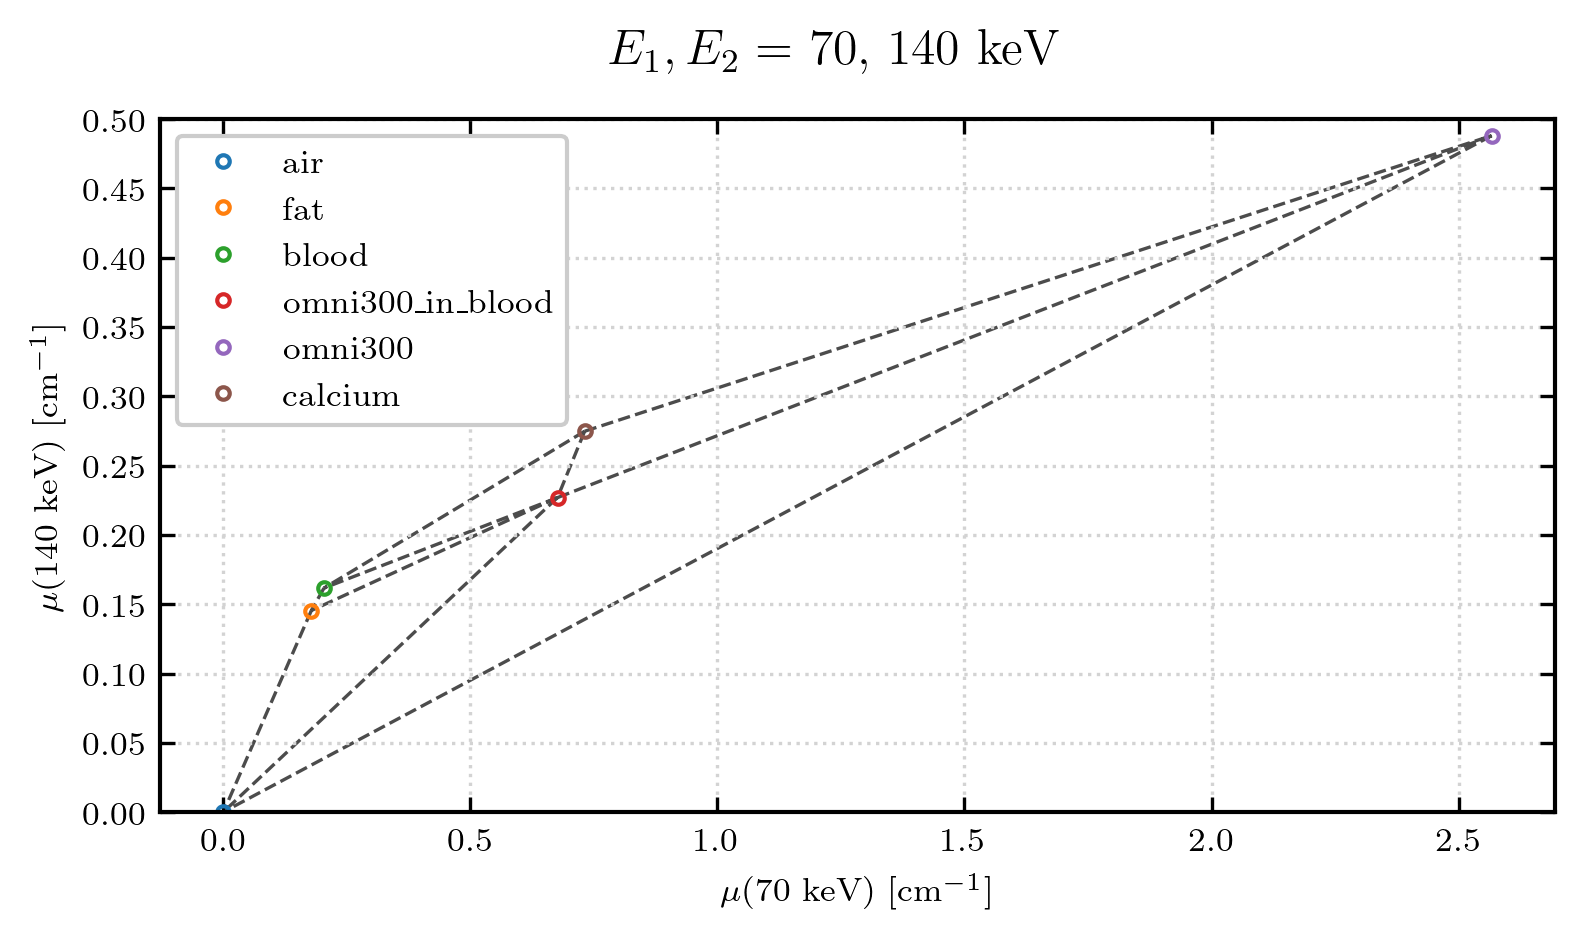

In [67]:
# basis materials
mats = []

### AIR
for name, density, matdict in [
    ['air', 1.205e-3, {6: 0.000124,
                     7: 0.755268,
                     8: 0.231781,
                     18: 0.012827}],
   ['fat', 0.950,   {1: 0.114000,
                     6: 0.598000,
                     7: 0.007000,
                     8: 0.278000,
                     11: 0.001000,
                     16: 0.001000,
                     17: 0.001000}],
   ['blood', 1.060, {1: 0.102000,
                     6: 0.110000,
                     7: 0.033000,
                     8: 0.745000,
                     11: 0.001000,
                     15: 0.001000,
                     16: 0.002000,
                     17: 0.003000,
                     19: 0.002000,
                     26: 0.001000}],
    #['bone_and_blood', 1, {}],
    # ['bone', 1.450,  {1: 0.065473,
    #                  6: 0.536942,
    #                  7: 0.021500,
    #                  8: 0.032084,
    #                  9: 0.167415,
    #                  20: 0.176585}],
    ['omni300_in_blood', 1.06, d_omni_in_blood],
    # omni density - 1.060? match to blood? https://www.ajnr.org/content/ajnr/28/9/1690.full.pdf
    ['omni300', 1.06, {1: 0.03191478751101292, # 1 mg/ml = 1e-3 g/cm3   
                         6: 0.2779110718133381,  # from periodictable
                         7: 0.05117301559050043,
                         8: 0.1753598375717305,
                         53: 0.46364128751341815}],
    ['calcium',  1.550, {20: 1.0}],
]:
    matcomp = convert_nist_str(matdict)
    mats.append([name, density, matcomp])

plot_tessel(mats)

# Defining materials

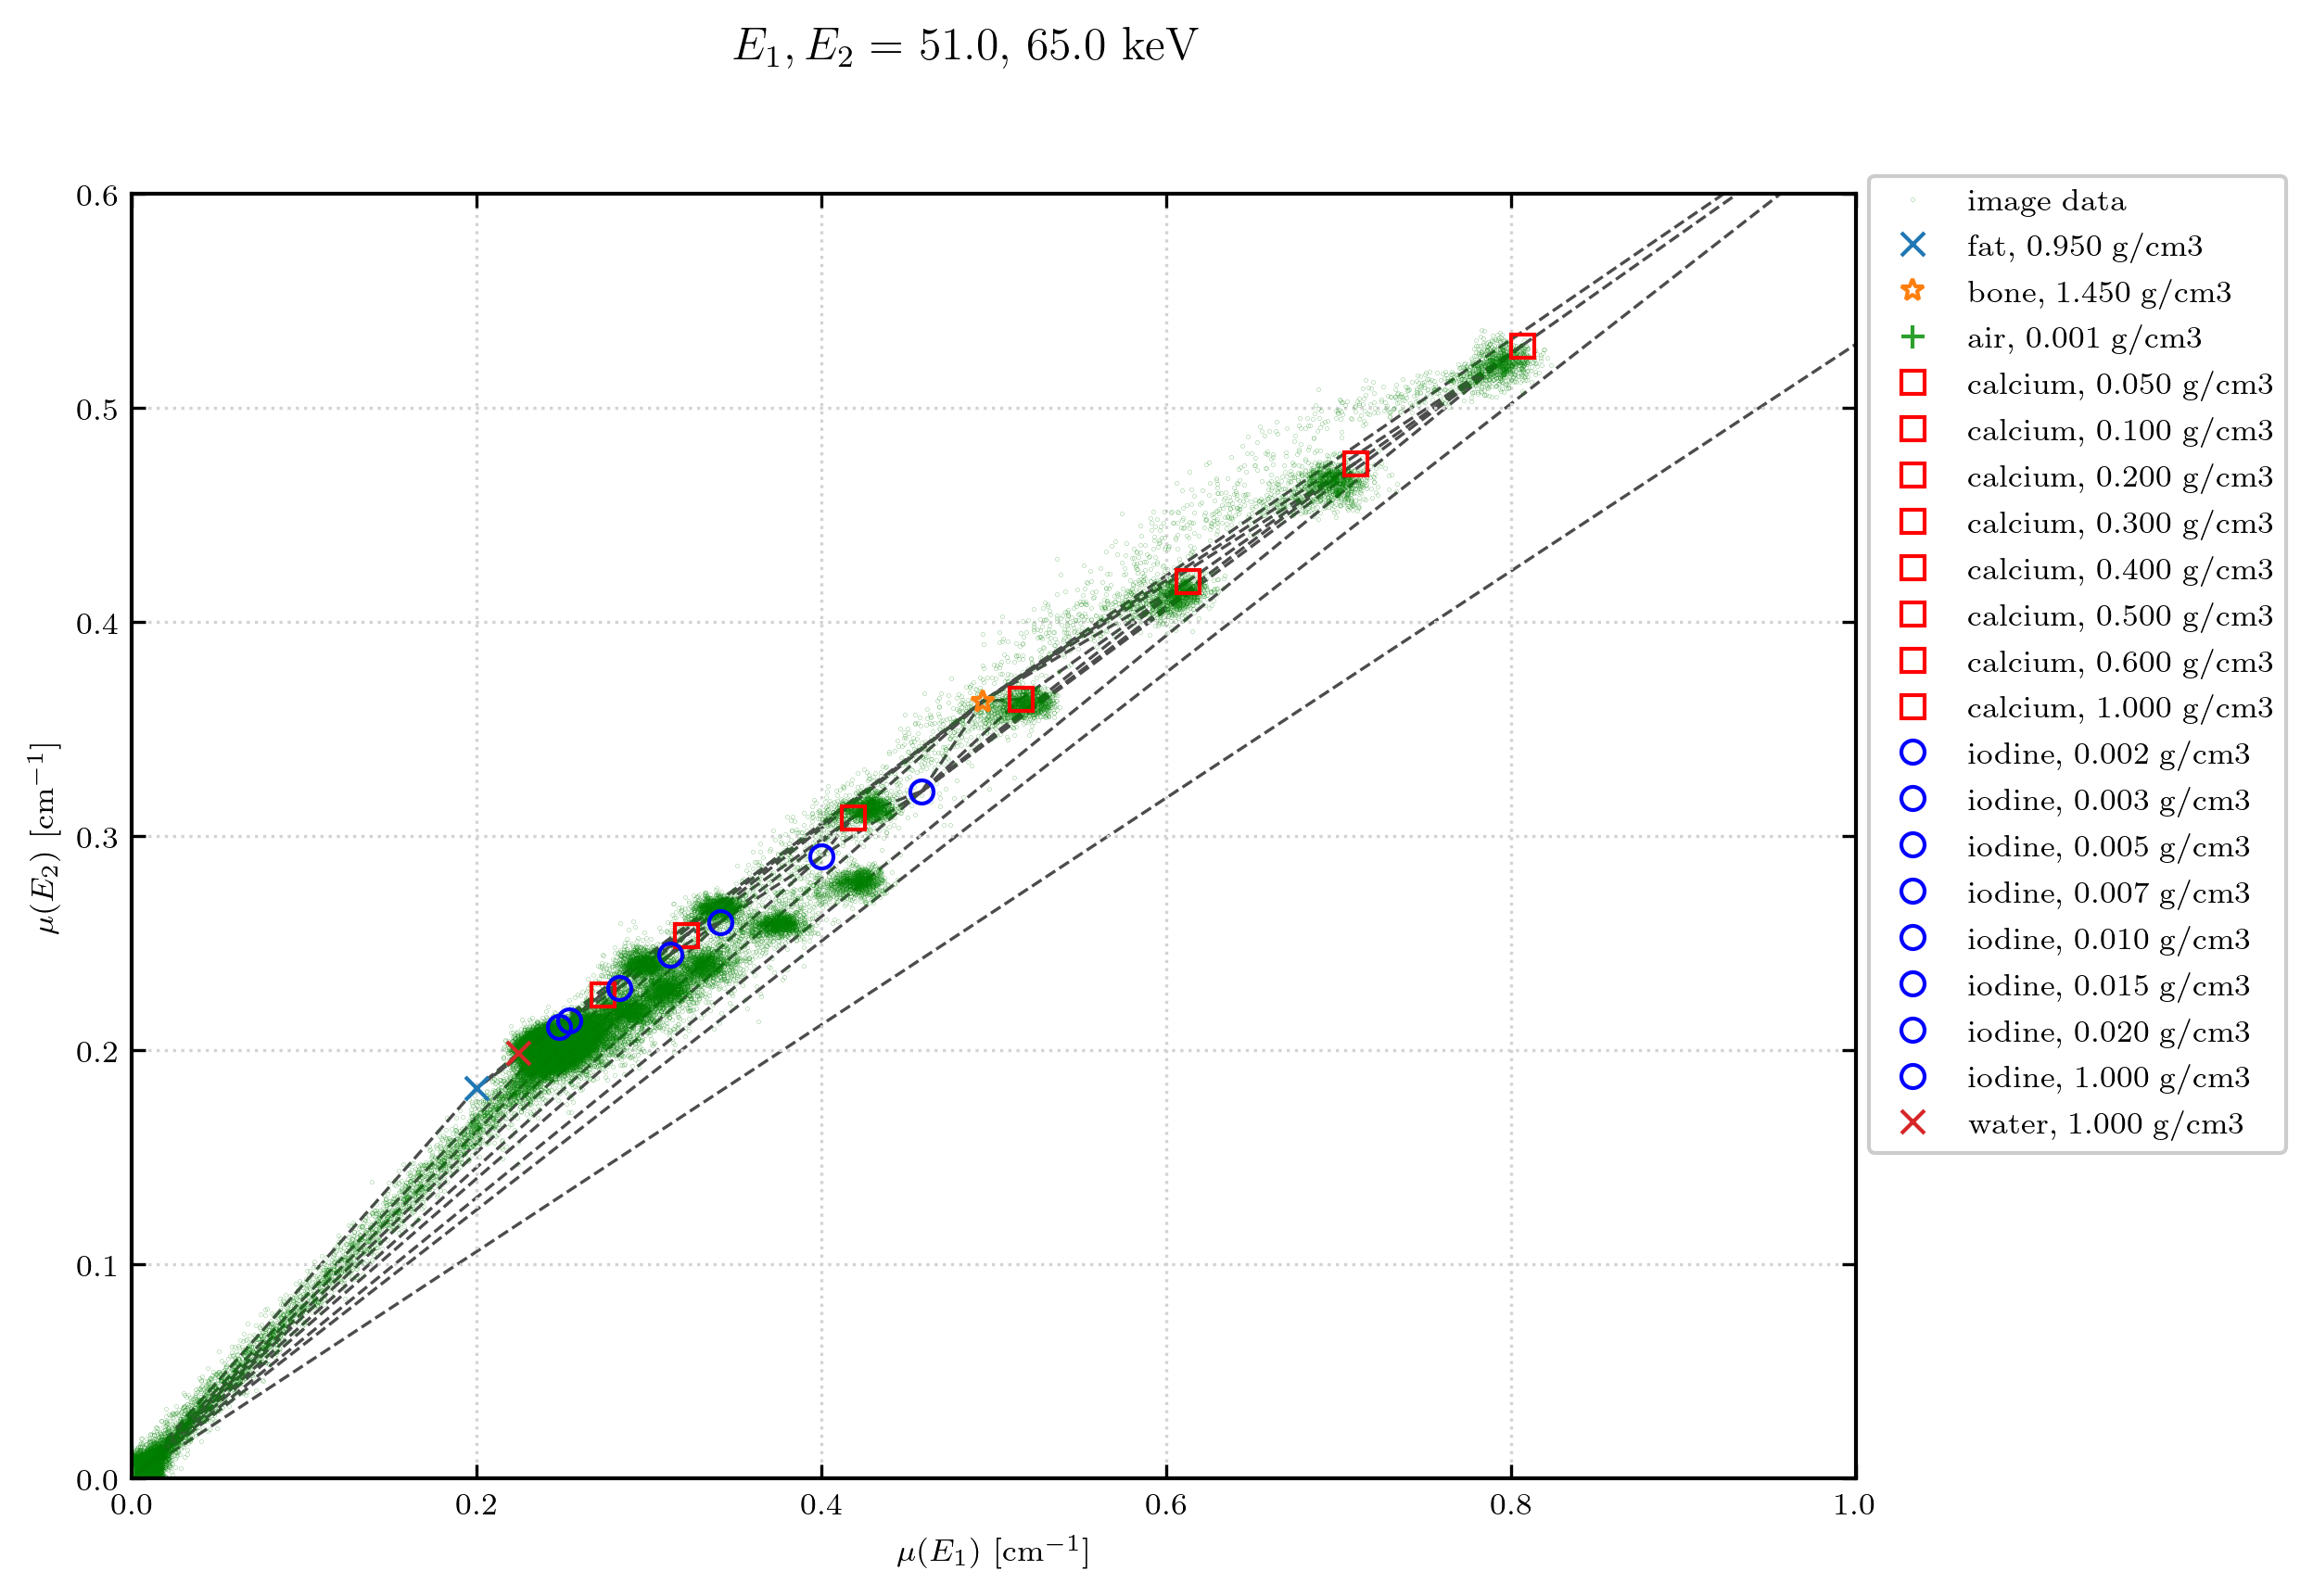

# Triple Material Decomposition (MD3)

In [5]:
# choose one triplet from our tesselation
triplet = np.take(mats, tri.simplices[1])
for mat in triplet:
    print(mat.name)
mu_triplet = np.array([m.mu for m in triplet])

iodine_in_water_20
water
air


In [21]:
# triple mat decomp (md3)
# compute volume fractions for known three materials

def md3(mu, triple):
    '''
    mu - vec of measured mu at E1, E2
    triple - triangle of truth mu vector coordinates
    solve for a (alphas) in Ma = x
    '''
    x = np.ones(3, dtype=np.float64)
    x[:2] = mu
    M = np.ones([3,3], dtype=np.float64)
    M[:2] = triple.T
    
    a = np.linalg.inv(M) @ x
    return a
    
def md2(mu, double):
    '''
    mu - vec of measured mu at E1, E2
    double - two truth mu vector coordinates
    solve for a (alphas) in Ma = x
    '''
    x = mu.astype(np.float64)
    M = double.T.astype(np.float64)
    
    a = np.linalg.inv(M) @ x
    return a

md3(mu_meas, mu_triplet)
    

array([ 0.76384318, -0.40430856,  0.64046538])

In [7]:
def tri_area(p1, p2, p3):
    area = 0.5 * (p1[0] * (p2[1] - p3[1]) 
            + p2[0] * (p3[1] - p1[1]) 
            + p3[0] * (p1[1] - p2[1]))
    return np.abs(area)

def md3_area(mu, triple):
    '''
    check that area interpretation from mendonca is equivalent
    '''
    A1 = tri_area(mu, triple[1], triple[2])
    A2 = tri_area(mu, triple[0], triple[2])
    A3 = tri_area(mu, triple[0], triple[1])
    A = np.array([A1, A2, A3])

    alphas = np.array([Ai/np.sum(A) for Ai in A])
    return alphas

md3_area(mu_meas, mu_triplet)

array([0.42233548, 0.22354569, 0.35411883])

# Multi-Triple Material Decomposition (MMD)

In [8]:

# choose optimal triangle
def is_inside(mu, triple, EPS=1e-8):
    '''
    a point P is inside a triangle ABC if 
    the sum of areas of PAB, PBC, PAC = area of ABC
    '''
    A = tri_area(triple[0], triple[1], triple[2])
    A1 = tri_area(mu, triple[0], triple[1])
    A2 = tri_area(mu, triple[1], triple[2])
    A3 = tri_area(mu, triple[0], triple[2])
    diff = np.abs(A-(A1+A2+A3))
    return diff < EPS
        
# in case the point is not inside the tesselation...
def d_hausdorff(mu, triple):
    '''
    mu - vec of measured mu at E1, E2
    triple - triangle of truth mu vector coordinates
    '''
    # make sure all numpy arrays
    mu = np.array(mu)
    triple = np.array(triple)

    # calc distance
    distances = np.zeros(3)
    for i in range(3):
        distances[i] = np.linalg.norm(triple[i] - mu)

    return np.min(distances)

def d_point_line(P0, P1, P2):
    '''
    calc distance between point P0 (x0,y0)
    and the line between P1 and P2
    '''
    # unpack coords
    x0, y0 = P0
    x1, y1 = P1
    x2, y2 = P2
    
    # line P1-P2
    m = (y2-y1)/(x2-x1)
    b = y1-m*x1

    # perpendicular line from P0 
    m0 = -1/m
    b0 = y0-m0*x0

    # intersection point
    xi = (b0-b)/(m-m0)
    yi = m*xi + b

    # distance Pi to P0
    d = np.sqrt((x0-xi)**2 + (y0-yi)**2)
    return d

def nearest_edge(mu, triple):
    line1 = [triple[0], triple[1]]
    line2 = [triple[1], triple[2]]
    line3 = [triple[0], triple[2]]

In [9]:

mu_test = mu_meas_out
#method = 'hausdorff' 
method = 'nearest_edge'

def get_alphas(mu_test, mats, tri):

    # init
    alphas = None
    min_hausdorff = 1e8  # something large
    
    for tri_inds in tri.simplices:
        triplet = np.take(mats, tri_inds)
        triplet_names = [m.name for m in triplet]
        mu_triplet = np.array([m.mu for m in triplet])   
    
        # first check triplets
        if is_inside(mu_test, mu_triplet):
            alphas = md3(mu_test, mu_triplet)
            break
    
        # if not in triplets, prepare minimum hausdorff dist
        d = d_hausdorff(mu_test, mu_triplet) 
        if d < min_hausdorff:
            min_hausdorff = d
            
    
    if alphas is None: # not inside tesselation, go back through
        for tri_inds in tri.simplices:
            triplet = np.take(mats, tri_inds)
            triplet_names = [m.name for m in triplet]
            mu_triplet = np.array([m.mu for m in triplet])
    
            d = d_hausdorff(mu_test, mu_triplet) 
            if d==min_hausdorff:
                if method=='hausdorff':
                    alphas = md3(mu_test, mu_triplet)
                else:
                    
                    a1, a2 = md2(
                    alphas = 
                break
    return triplet_names, alphas

triplet_names, alphas = get_alphas(mu_test, mats, tri)
print(triplet_names, alphas)

['calcium', 'iodine_in_water_20', 'air'] [-0.10645348  1.62308049 -0.516627  ]


# Test an image

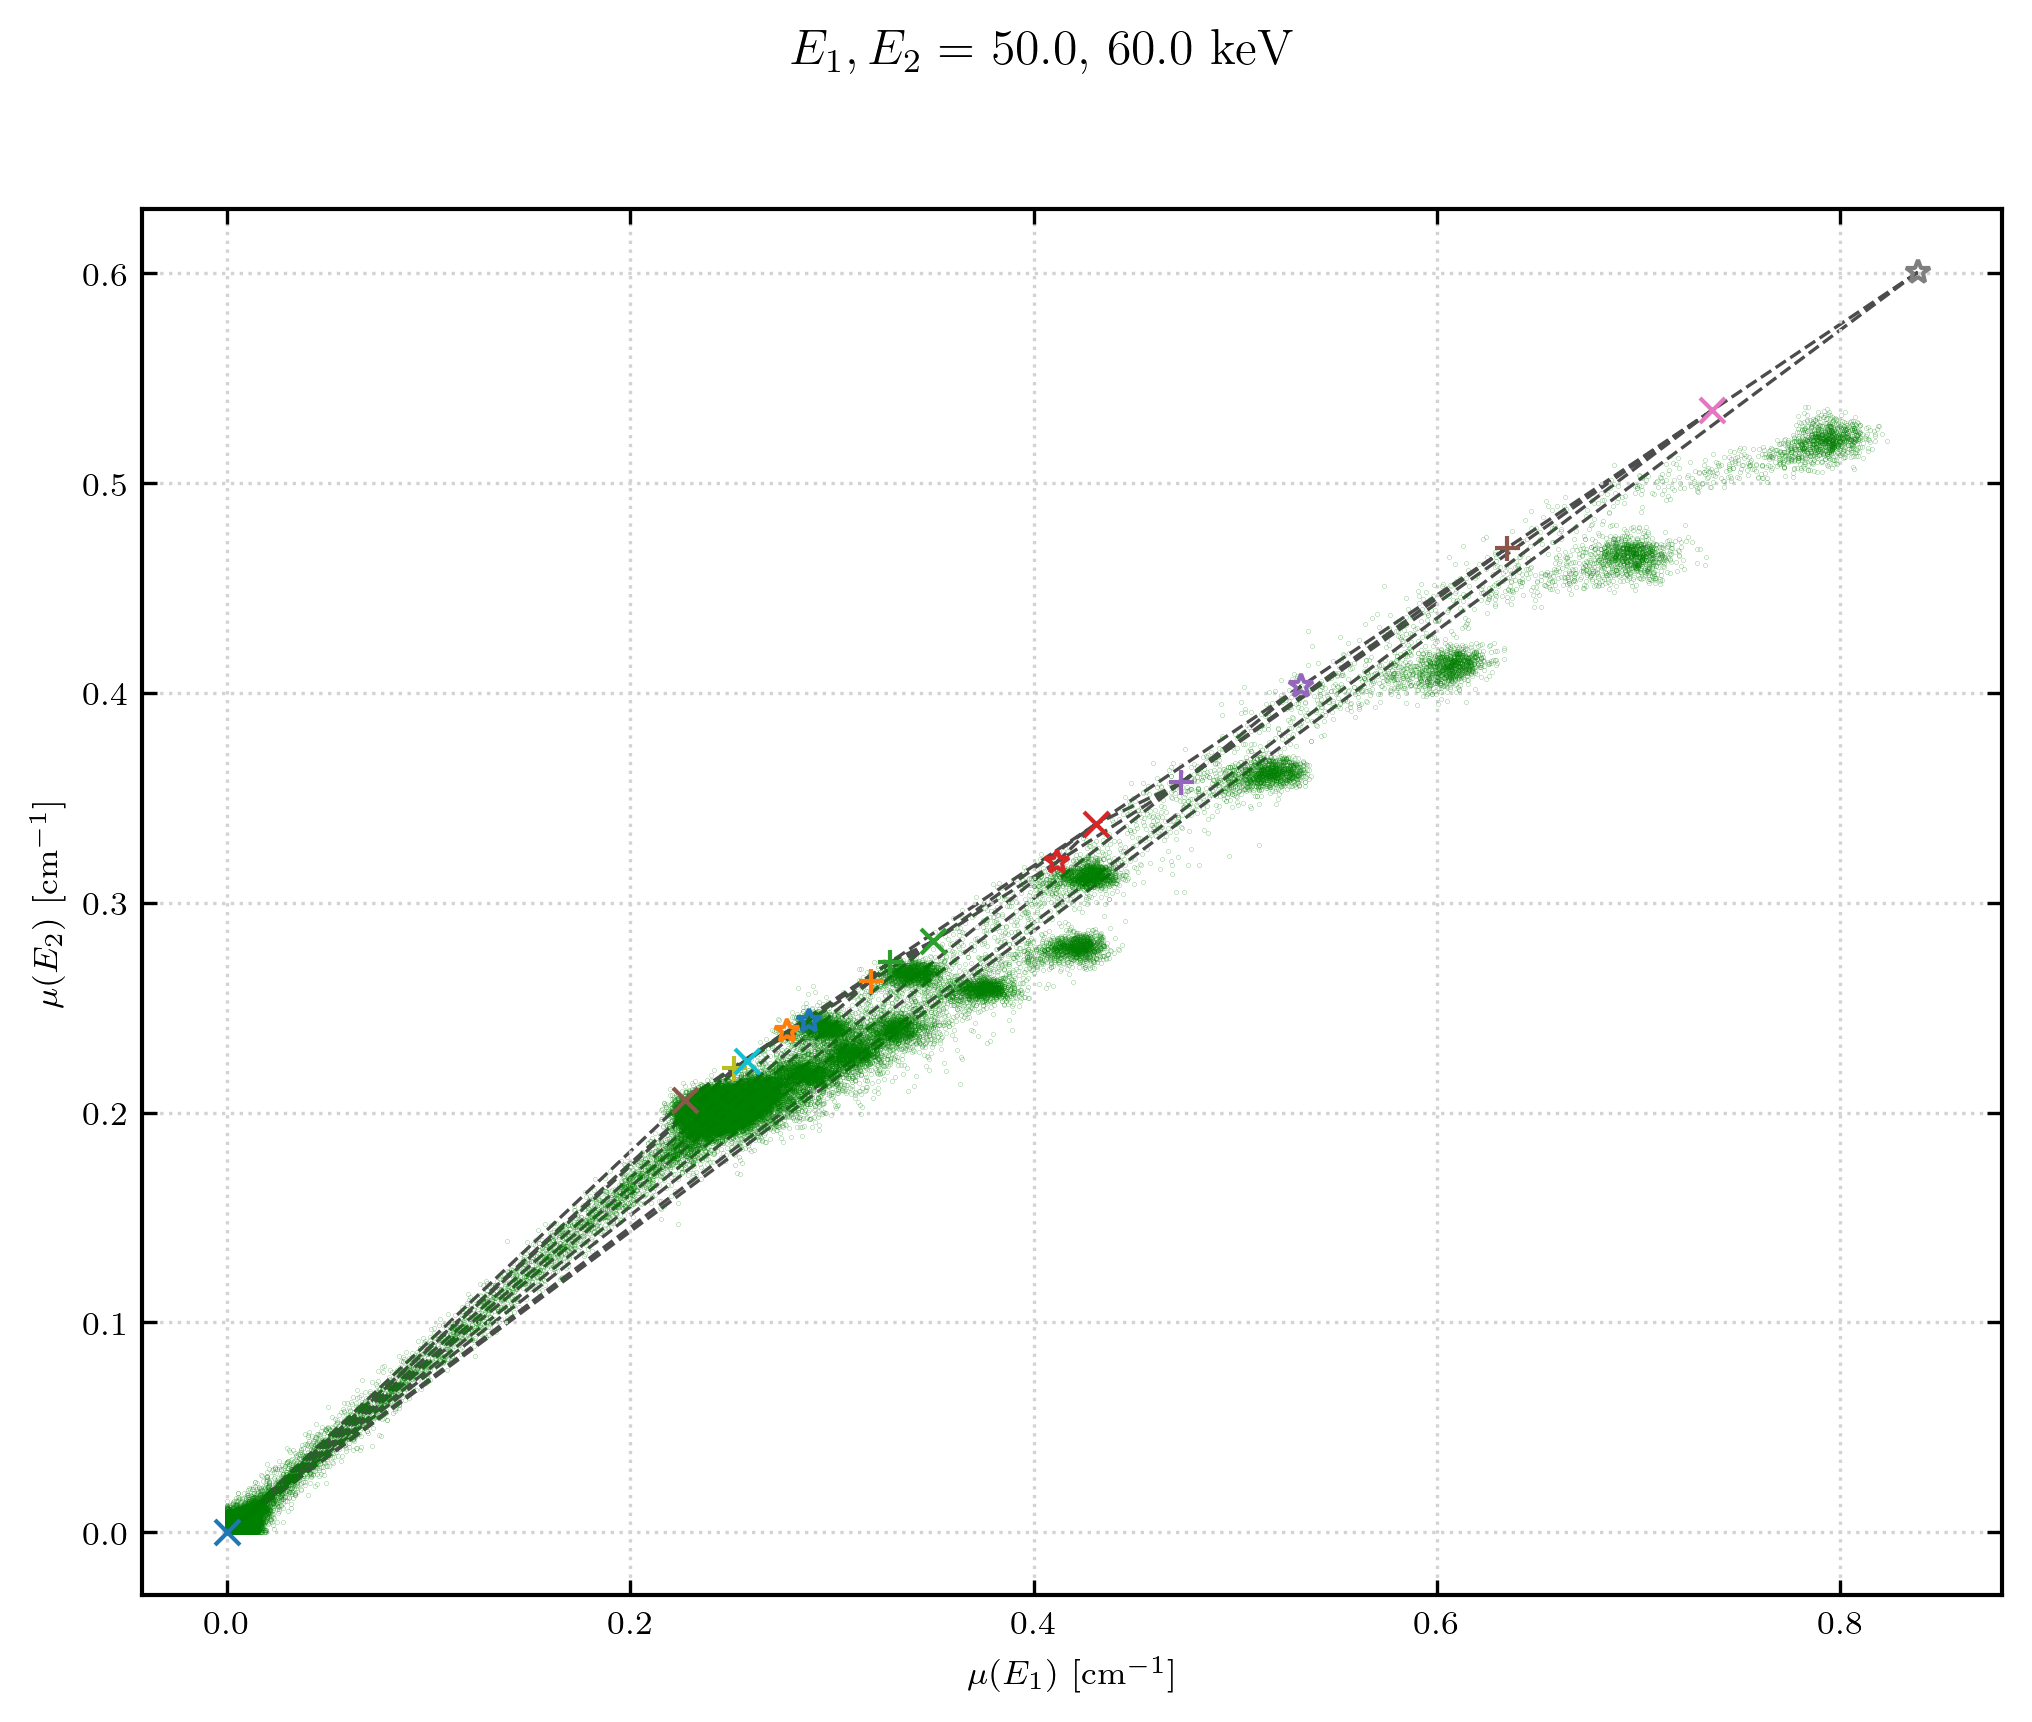

In [17]:
M_E1 = np.fromfile('input/data_13062023/test_imgs/M_E1.npy', dtype=np.float32).reshape([512,512])
M_E2 = np.fromfile('input/data_13062023/test_imgs/M_E2.npy', dtype=np.float32).reshape([512,512])

fig, ax = plt.subplots(1,1, figsize=[8,6])
fig.suptitle(f'$E_1, E_2 =$ {E1}, {E2} keV')

plt.plot(M_E1.ravel(), M_E2.ravel(), 'g.', markersize=.1, label='image data')

ax.triplot(points[:,0], points[:,1], tri.simplices, 'k--', lw=.8, alpha=0.7)
for mat in mats:
    ax.plot(mat.mu[0], mat.mu[1], marker=next(marker), ls='', markerfacecolor='None', label=mat.name)

#ax.plot([0,0.8],[0.07,0.52],'r-')
ax.set_xlabel('$\mu(E_1)$ [cm$^{-1}$]')
ax.set_ylabel('$\mu(E_2)$ [cm$^{-1}$]')
#ax.legend()
plt.show()

In [11]:
# initialize basis images
M_dict = {}
for m in mats:
    M_dict[m.name] = np.zeros([512,512], dtype=np.float32)

# compute images
for i in range(512):
    for j in range(512):
        mu_px = np.array([M_E1[i,j], M_E2[i,j]])
        triplet_names, alphas = get_alphas(mu_px, mats, tri)
        for k, name in enumerate(triplet_names):
            M_dict[name][i,j] = alphas[k]

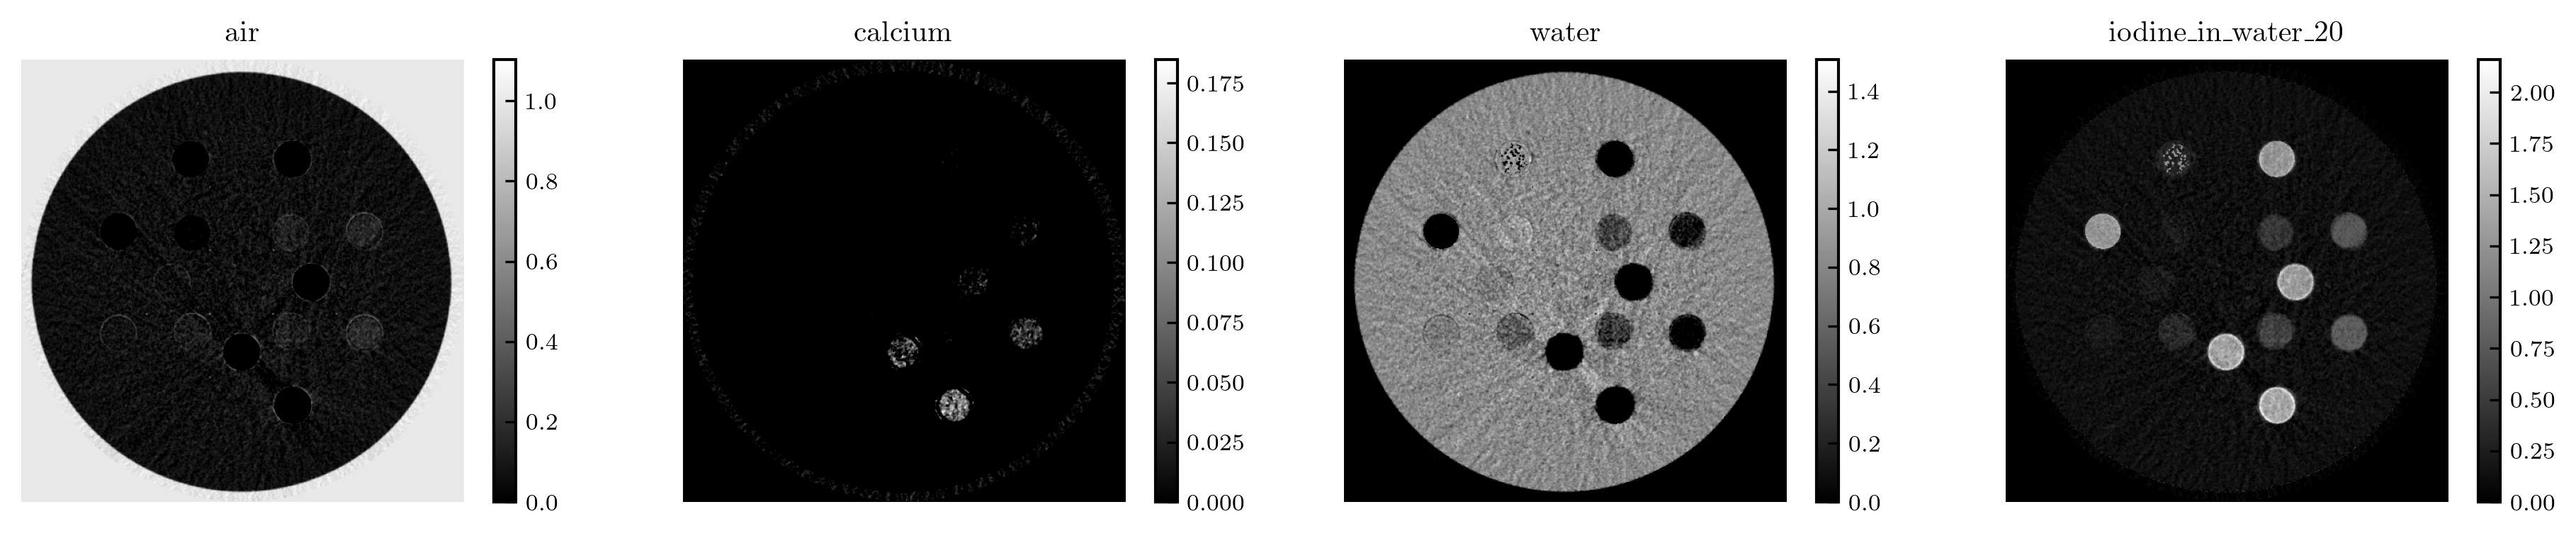

In [12]:
scale = 2.5
fig, ax = plt.subplots(1,len(M_dict),figsize=[(len(M_dict)+1)*scale, scale])
for i, name in enumerate(M_dict):
    ax[i].set_title(name)
    m = ax[i].imshow(M_dict[name], cmap='gray', vmin=0)#, vmax=1)
    fig.colorbar(m, ax=ax[i])
    ax[i].grid(False)
    ax[i].axis('off')
fig.tight_layout()
plt.show()

# Putting everything together

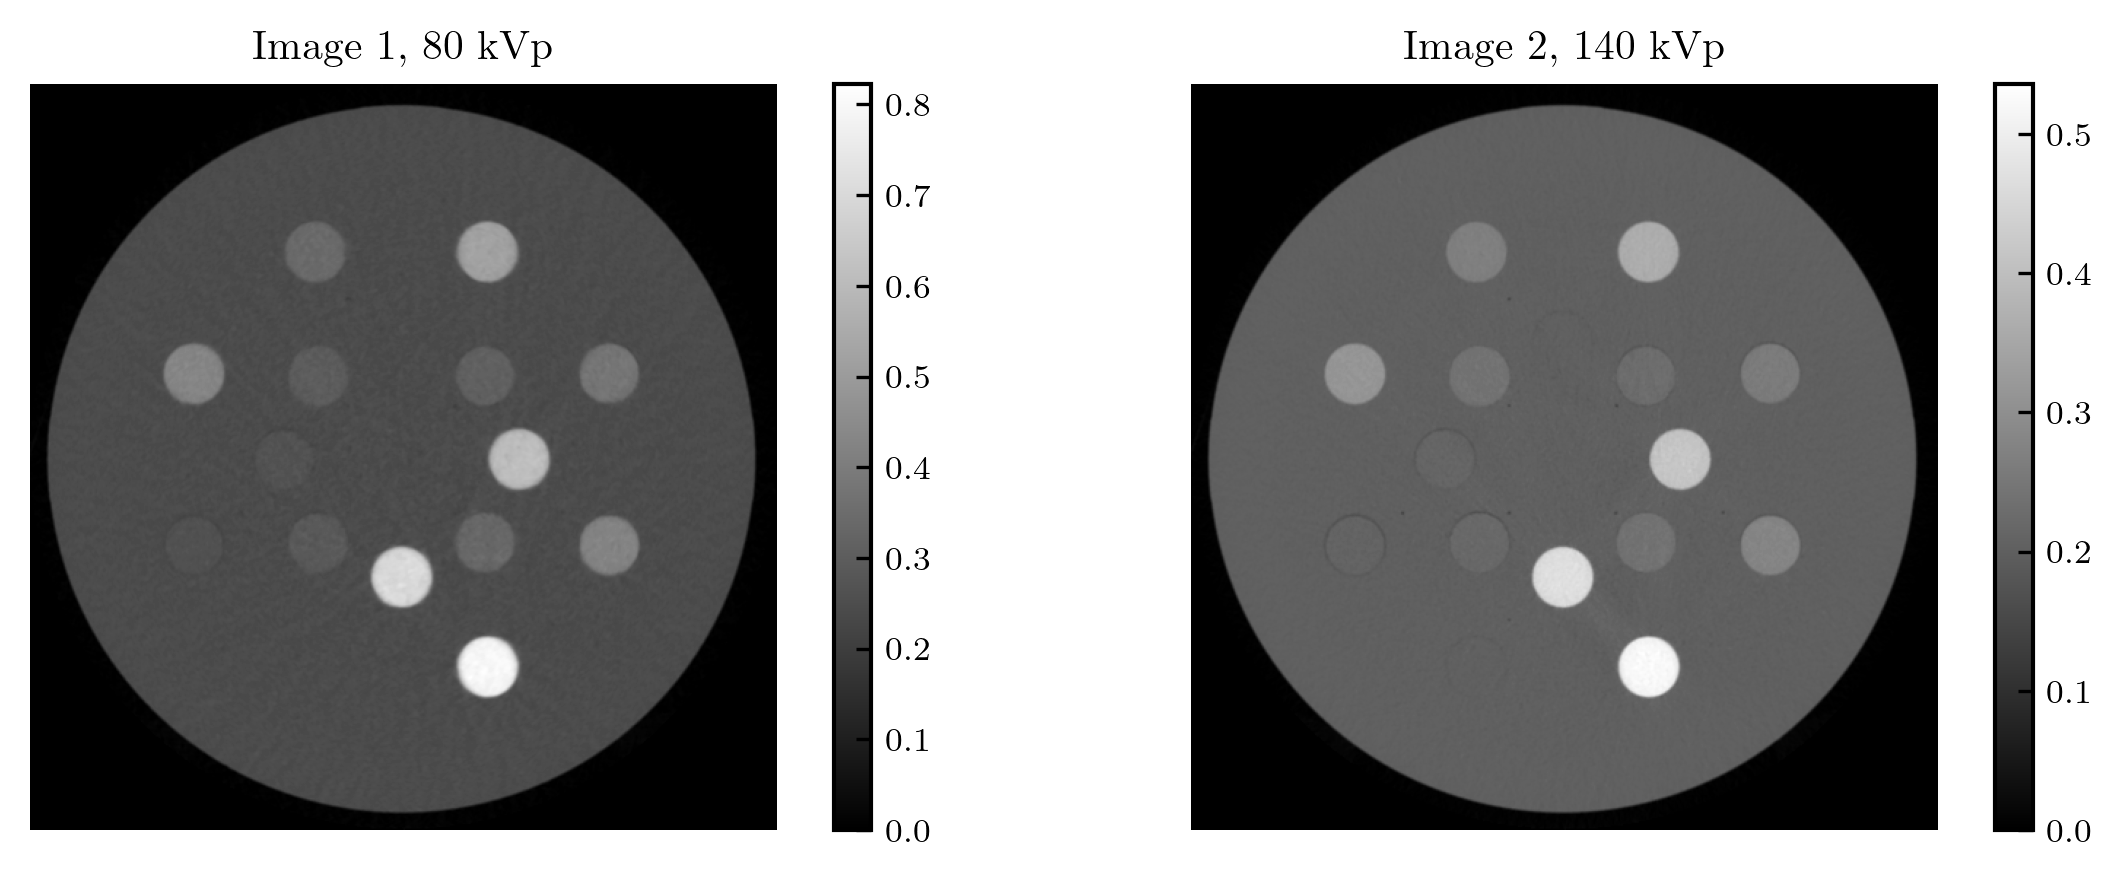

priority list of material triplets:
1 ['calcium', 'iodine_in_water_20', 'air']
2 ['iodine_in_water_20', 'water', 'air']
3 ['water', 'iodine_in_water_20', 'calcium']



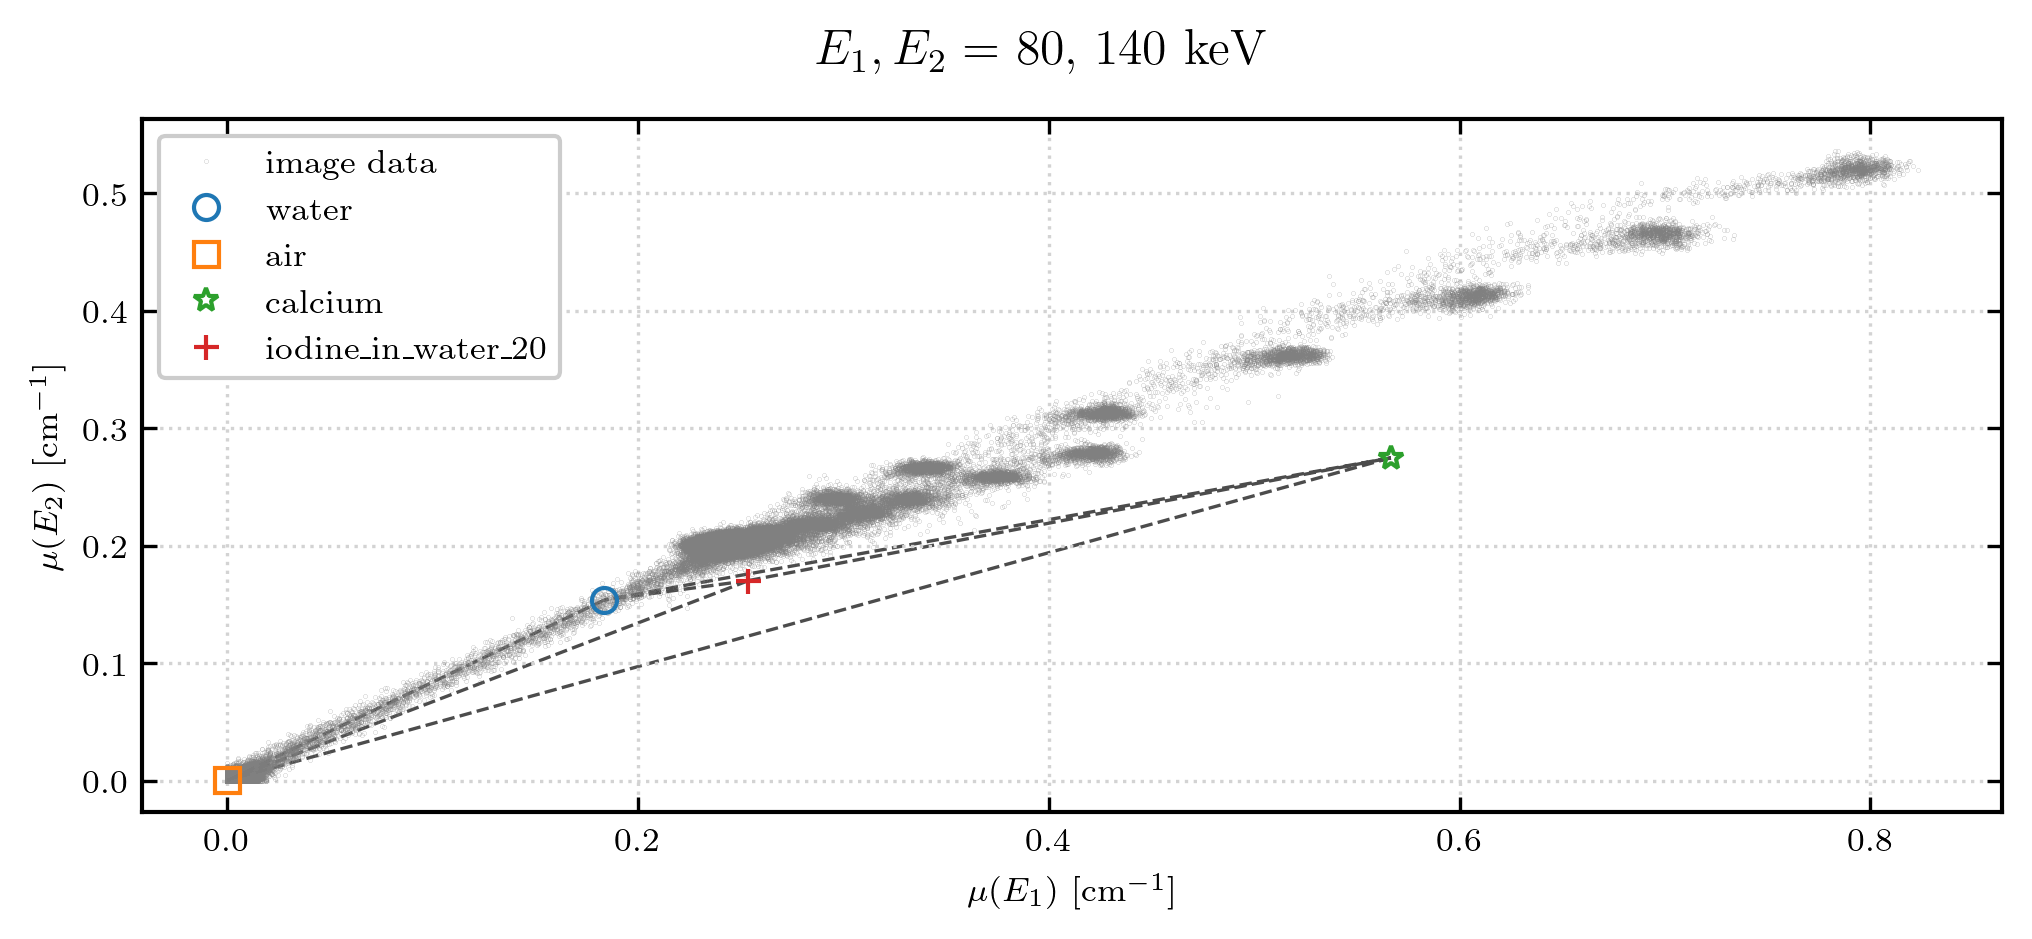

1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


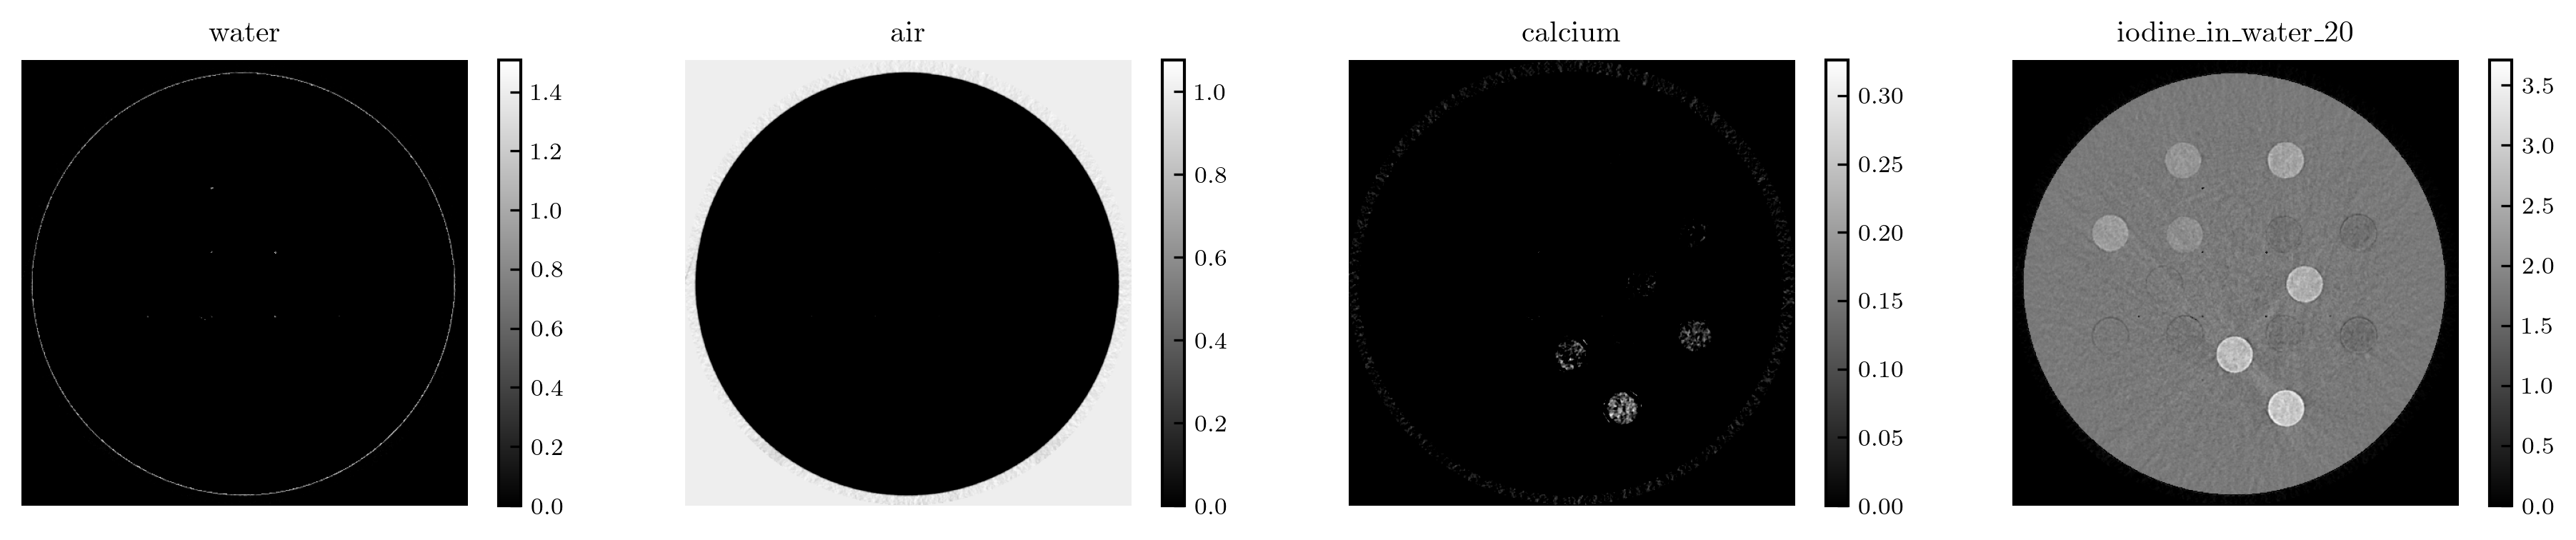

In [19]:
def mmd(material_dict, material_names, E_eff, img_E1, img_E2, show_images=True, show_triples=True, show_basis_images=True):

    E1, E2 = E_eff
    
    ### PART 1
    # create a list of Materials
    mats = []
    for m in material_names:
        mats.append(material_dict[m])
        
    # show the images
    if show_images:
        fig, ax = plt.subplots(1,2, figsize=[8,3])
        ax[0].set_title(f'Image 1, 80 kVp')
        ax[0].axis('off')
        m = ax[0].imshow(img_E1, cmap='gray')
        fig.colorbar(m, ax=ax[0])
        ax[1].set_title(f'Image 2, 140 kVp')
        ax[1].axis('off')
        m = ax[1].imshow(img_E2, cmap='gray')
        fig.colorbar(m, ax=ax[1])
        fig.tight_layout()
        plt.show()

    #### PART 2
    # initialize attenuation coeff vectors 
    # create full tesselation of triplets
    points = []
    for mat in mats:
        mat.init_atten_coeffs(E_eff)
        points.append(mat.mu)
    points = np.array(points)
    tri = Delaunay(points)

    # print priority list of triplets
    print('priority list of material triplets:')
    for i, tri_inds in enumerate(tri.simplices):
        triplet = np.take(mats, tri_inds)
        triplet_names = [m.name for m in triplet]
        print(i+1, triplet_names)
    print()

    # show the triples
    if show_triples:
        fig, ax = plt.subplots(1,1, figsize=[8,3])
        fig.suptitle(f'$E_1, E_2 =$ {E1}, {E2} keV')
        plt.plot(img_E1.ravel(), img_E2.ravel(), marker='.', color='gray', ls='', markersize=.1, label='image data')
        ax.triplot(points[:,0], points[:,1], tri.simplices, 'k--', lw=.8, alpha=0.7)
        for mat in mats:
            ax.plot(mat.mu[0], mat.mu[1], marker=next(marker), ls='', markerfacecolor='None', label=mat.name)
        ax.set_xlabel('$\mu(E_1)$ [cm$^{-1}$]')
        ax.set_ylabel('$\mu(E_2)$ [cm$^{-1}$]')
        ax.legend()
        plt.show()

        
    #### PART 3
    # compute basis material images
    M_dict = {}
    for m in mats:
        M_dict[m.name] = np.zeros([512,512], dtype=np.float32)

    # compute images
    for i in range(512):
        if i in [x for x in range(0, 512,512//10)]:
            print(f'{int(100*i/512)+1}%')
        for j in range(512):
            mu_px = np.array([img_E1[i,j], img_E2[i,j]])
            triplet_names, alphas = get_alphas(mu_px, mats, tri)
            for k, name in enumerate(triplet_names):
                M_dict[name][i,j] = alphas[k]
                
    # show images
    if show_basis_images:
        scale = 2.5
        fig, ax = plt.subplots(1,len(M_dict),figsize=[(len(M_dict)+1)*scale, scale])
        for i, name in enumerate(M_dict):
            ax[i].set_title(name)
            m = ax[i].imshow(M_dict[name], cmap='gray', vmin=0)#, vmax=1)
            fig.colorbar(m, ax=ax[i])
            ax[i].grid(False)
            ax[i].axis('off')
        fig.tight_layout()
        plt.show()

matnames = ['water',  'air', 'calcium', 'iodine_in_water_20']
E_vec = [80, 140]
mmd(mdict, matnames, E_vec, M_E1, M_E2)


priority list of material triplets:
1 ['iodine', 'calcium', 'air']
2 ['calcium', 'water', 'air']



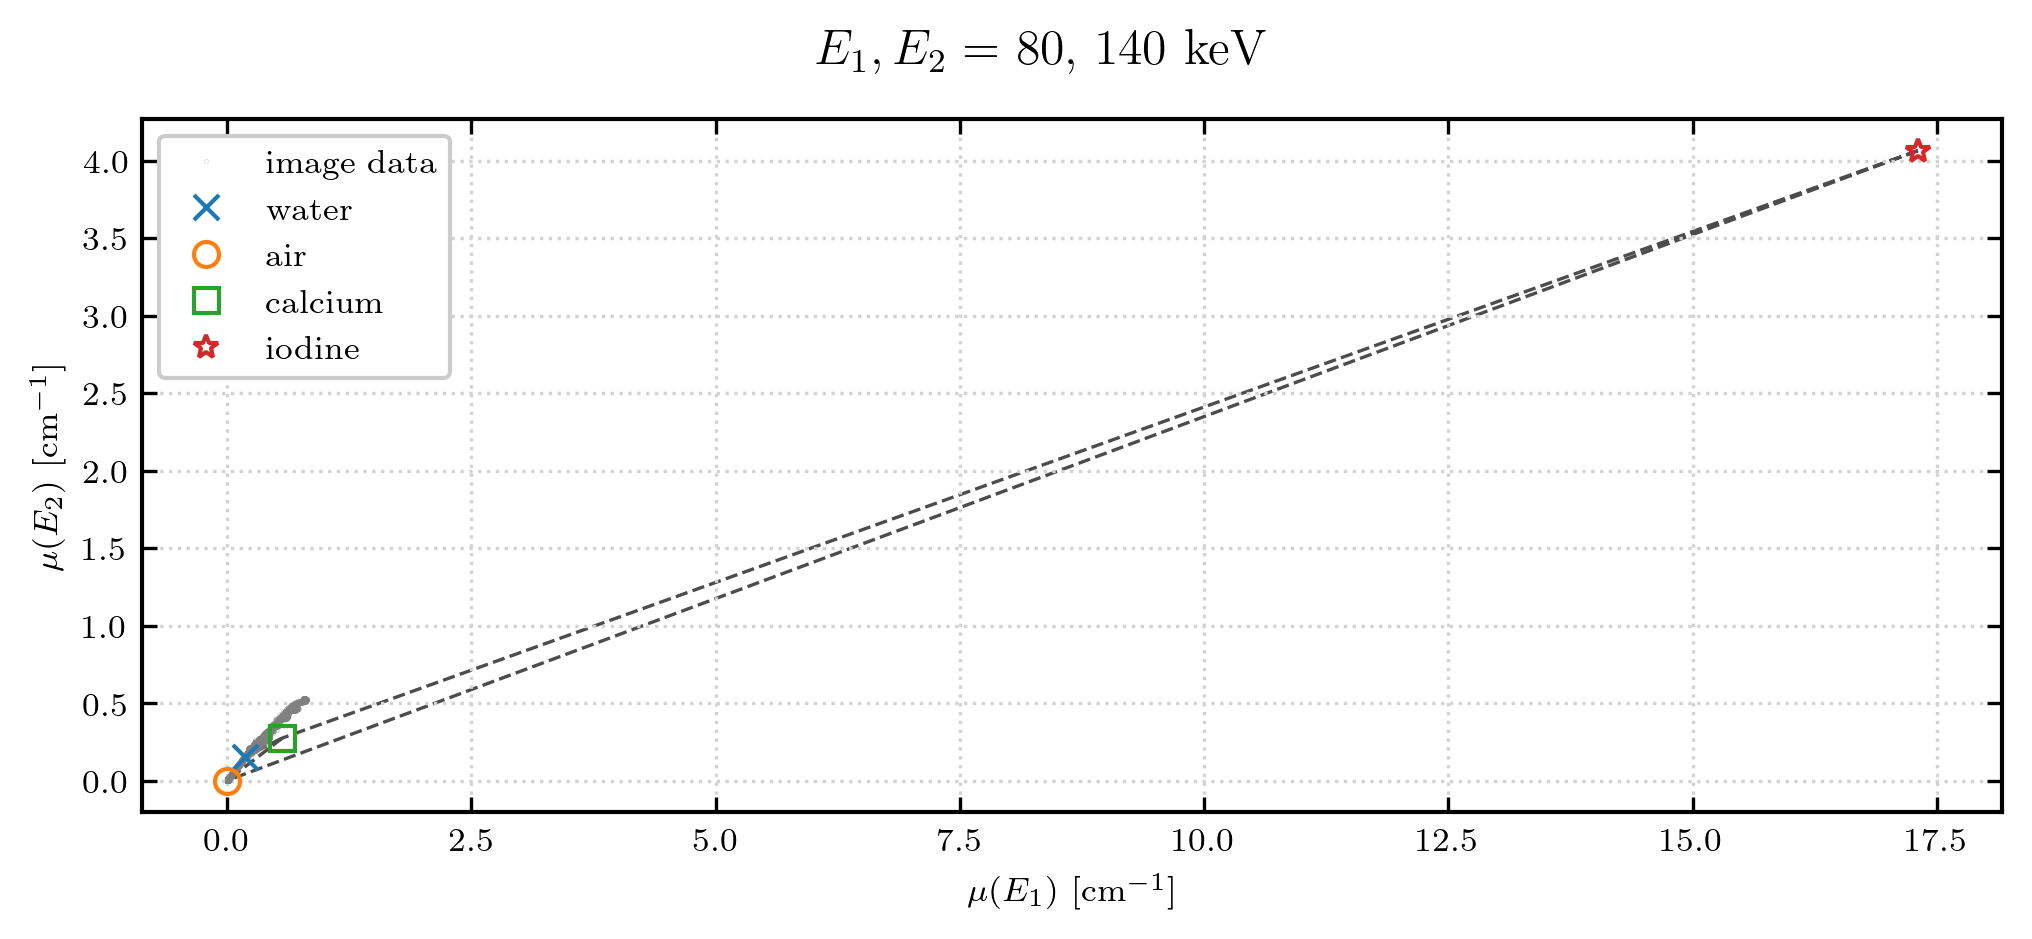

1%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


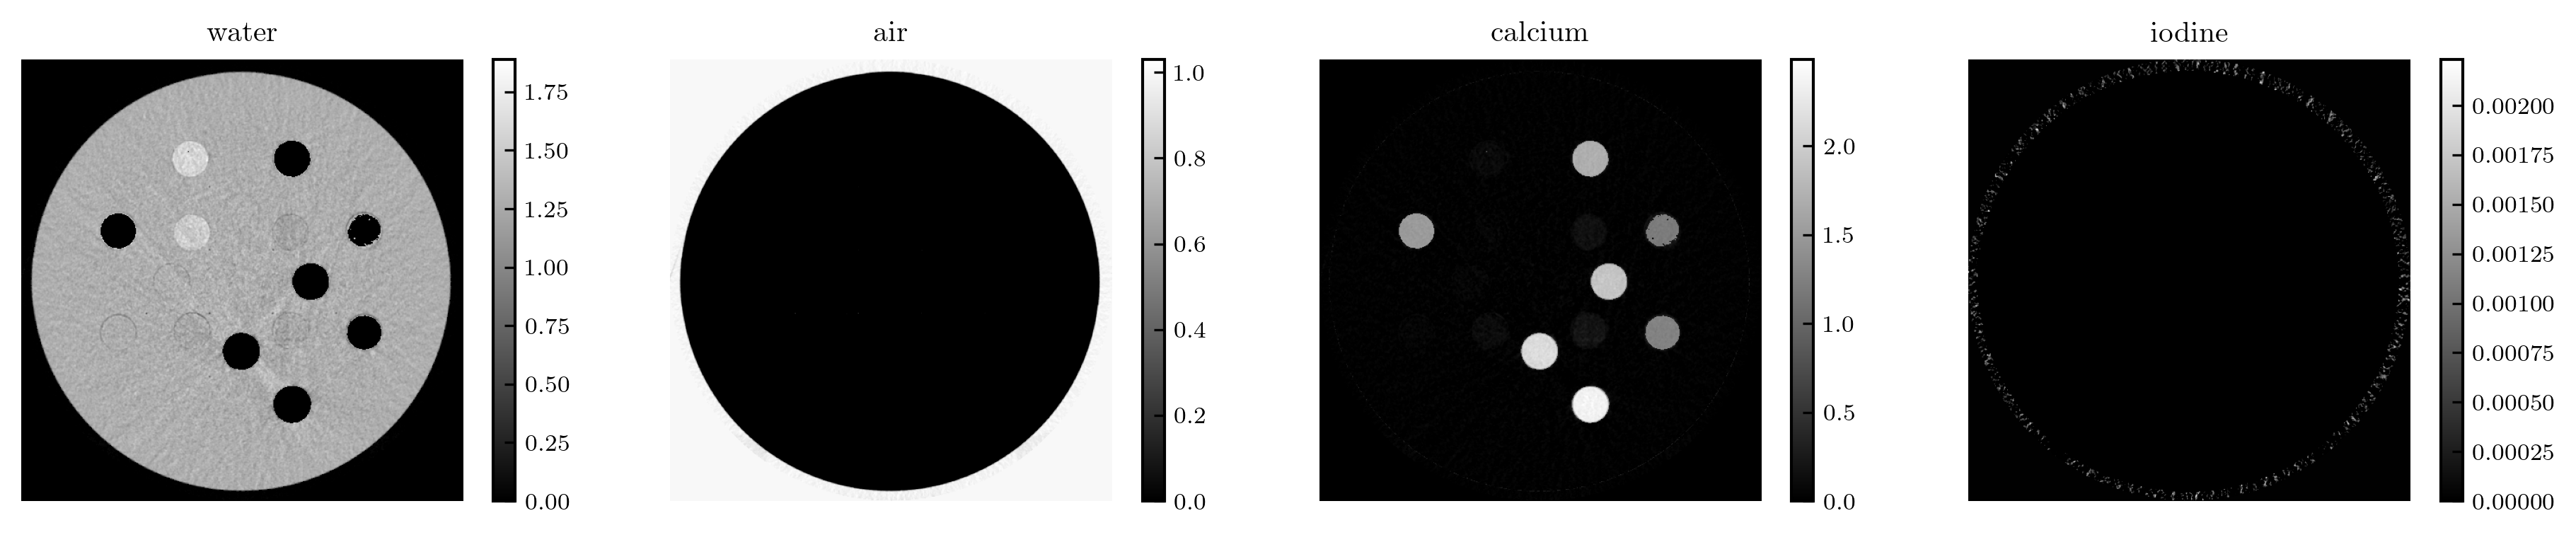

In [20]:
matnames = ['water',  'air', 'calcium', 'iodine']
mmd(mdict, matnames, E_vec, M_E1, M_E2, show_images=False)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from xcompy import mixatten
from materials import Material, convert_nist_str
from periodictable import elements


vitreous_body H(11.1898)O(88.8102)
eye_lens H(9.6000)C(19.5000)N(5.7000)O(64.6000)Na(0.1000)P(0.1000)S(0.3000)Cl(0.1000)


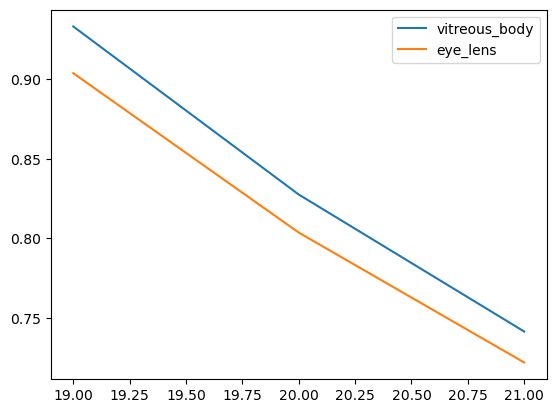

In [29]:
Fat = Material(   'fat', 
    0.950,
    {1: 0.114000,
     6: 0.598000,
     7: 0.007000,
     8: 0.278000,
     11: 0.001000,
     16: 0.001000,
     17: 0.001000})

Tissue = Material(  'tissue_soft',
     1.060,
     {1: 0.102000,
      6: 0.143000,
      7: 0.034000,
      8: 0.708000,
      11: 0.002000,
      15: 0.003000,
      16: 0.003000,
      17: 0.002000,
      19: 0.003000})

Water = Material(  'water',
     1.0,
     {1: 0.111898,
      8: 0.888102})

VitreousBody = Material(  'vitreous_body',
     1.022,
     {1: 0.111898,
      8: 0.888102})

EyeLens = Material( 'eye_lens',
        1.070,
        {1: 0.096000,
        6: 0.195000,
        7: 0.057000,
        8: 0.646000,
        11: 0.001000,
        15: 0.001000,
        16: 0.003000,
        17: 0.001000})

e = np.arange(19,22,1.0)
#for mat in [Fat, Tissue, Water, EyeLens]:
for mat in [VitreousBody, EyeLens]:
    print(mat.name, convert_nist_str(mat.matcomp_dict))
    mac, lac = mat.init_atten_coeffs(e)
    plt.plot(e, lac, label=mat.name)
plt.legend()
plt.show()
